# Segmentation Example

A really nice example from [sci-py lecture notes](http://www.scipy-lectures.org/advanced/image_processing/index.html#measuring-objects-properties-ndimage-measurements).

First, let's set up the imports and define a couple of custom display functions.

In [1]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
import warnings
warnings.filterwarnings('ignore')

def plotOneImage(dat, label, sFont=12, size=(10,10), colormap=plt.cm.gray):
    """plotOneImage(dat, label, sizeFont=12, size=(10,10), colormap=plt.cm.gray)
    Use matplotlib to plot the image
    Input:
    dat      - a numpy array with the data
    label    - a title
    sFont    - the size of the font, default 12
    size     - a tuple, default (10,10) with the figure size
    colormap - a pyplot color map, default plt.cm.gray
    Return:
    a matplotlib figure"""
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=size)
    ax0 = axes 
    ax0.imshow(dat, cmap=colormap, interpolation='nearest')
    ax0.set_title(label, fontsize=sFont)
    ax0.axis('off')
    fig.show()
    return(fig)

## First, generate the image.

In [2]:
np.random.seed(42) # Hey, I like the Hitchhiker's Guide to the Universe...
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = (im > im.mean()).astype(np.float)
mask += 0.1 * im
img = mask + 0.2*np.random.randn(*mask.shape)

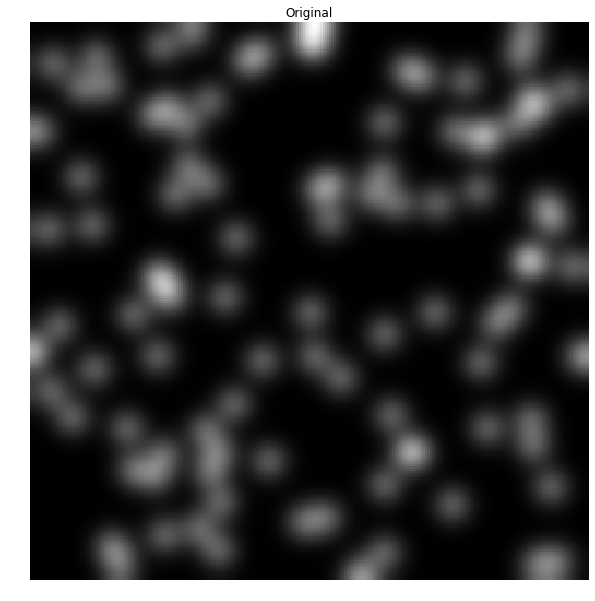

In [3]:
oriFig = plotOneImage(im, "Original", sFont=12, size=(10,10), colormap=plt.cm.gray)
oriFig.show()

## Generate touching blobs.

Select the mean gray level as a threshold and create a mask image with white blobs.

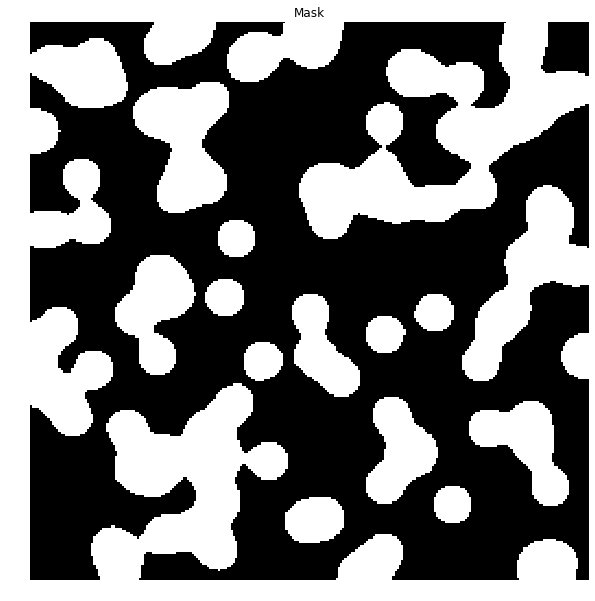

In [4]:
mask = (im > im.mean()).astype(np.float)
mask += 0.1 * im
mFig = plotOneImage(mask, "Mask", sFont=12, size=(10,10), colormap=plt.cm.gray)
mFig.show()

Now create a noisy image.

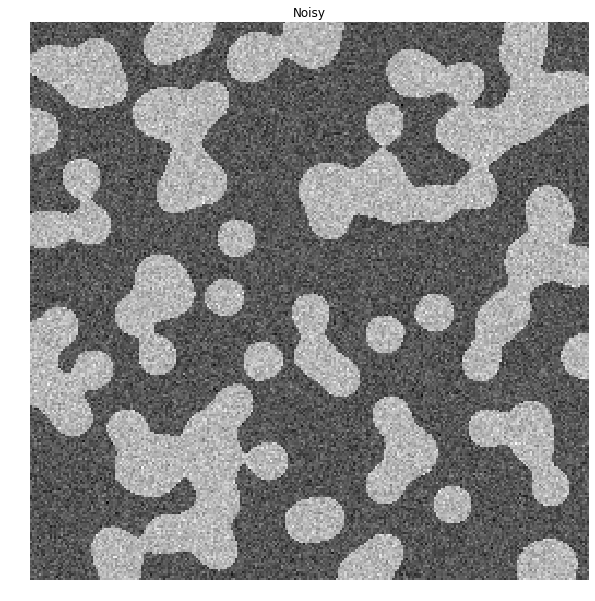

In [5]:
img = mask + 0.2*np.random.randn(*mask.shape)
nFig = plotOneImage(img, "Noisy", sFont=12, size=(10,10), colormap=plt.cm.gray)
nFig.show()

Now compute the histogram and binarize the image.

In [6]:
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
binary_img = img > 0.5

Finally make a nice side by side plot.

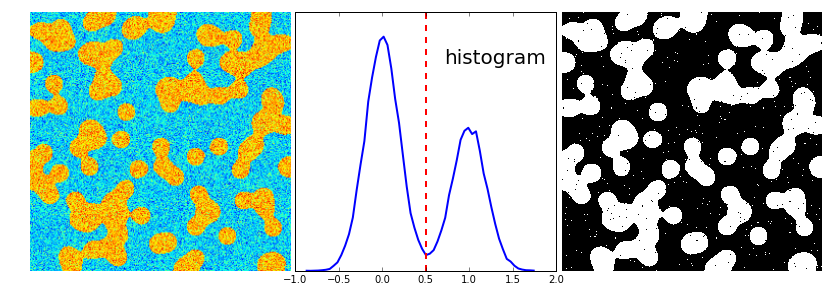

In [7]:
plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.subplot(132)
plt.plot(bin_centers, hist, lw=2)
plt.axvline(0.5, color='r', ls='--', lw=2)
plt.text(0.57, 0.8, 'histogram', fontsize=20, transform = plt.gca().transAxes)
plt.yticks([])
plt.subplot(133)
plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

Note that we have a noisy, binarized image. Use mathematical morphology to clean it up.

In [8]:
# Remove small white regions
open_img = ndimage.binary_opening(binary_img)
# Remove small black hole
close_img = ndimage.binary_closing(open_img)

Let's plot the result. For visiblility, we will just plot the top left quadrant of the image. 

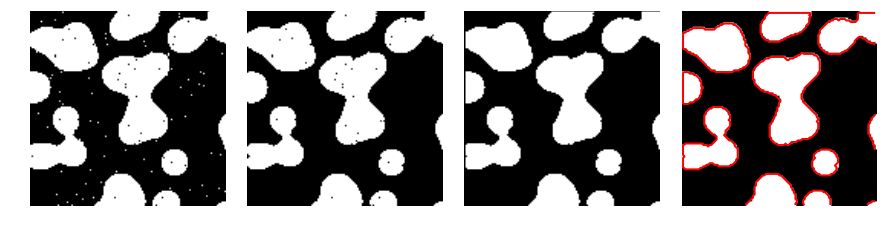

In [9]:
plt.figure(figsize=(12, 3))
l = 128
plt.subplot(141)
plt.imshow(binary_img[:l, :l], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(142)
plt.imshow(open_img[:l, :l], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(143)
plt.imshow(close_img[:l, :l], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(144)
plt.imshow(mask[:l, :l], cmap=plt.cm.gray)
plt.contour(close_img[:l, :l], [0.5], linewidths=2, colors='r')
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

Show that reconstruction operations (erosion + propagation) produce a better result than opening/closing.

In [10]:
eroded_img = ndimage.binary_erosion(binary_img)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=binary_img)
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
reconstruct_final = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))
np.abs(mask - close_img).mean() 

np.abs(mask - reconstruct_final).mean() 

0.00077811755977986031

Other Scientific Packages provide algorithms that can be useful for image processing. In this example, we use the spectral clustering function of the `scikit-learn` in order to segment touching objects.

## Generate some noisy, touching circles

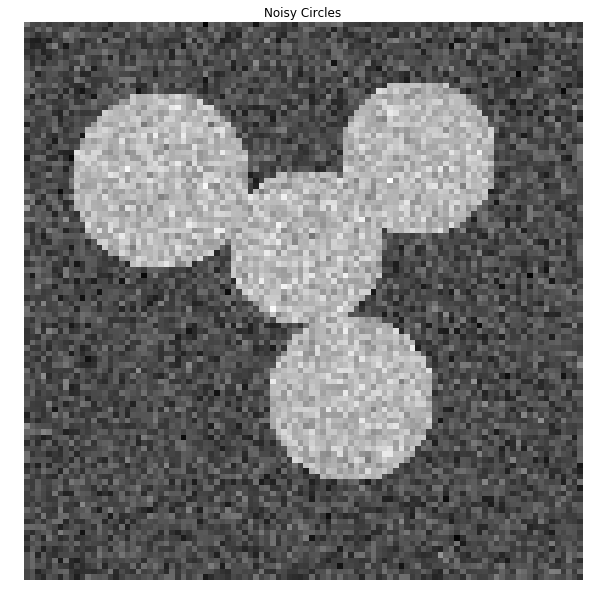

In [11]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0])**2 + (y - center1[1])**2 < radius1**2
circle2 = (x - center2[0])**2 + (y - center2[1])**2 < radius2**2
circle3 = (x - center3[0])**2 + (y - center3[1])**2 < radius3**2
circle4 = (x - center4[0])**2 + (y - center4[1])**2 < radius4**2

# 4 circles
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2*np.random.randn(*img.shape)


cFig = plotOneImage(img, "Noisy Circles", sFont=12, size=(10,10), colormap=plt.cm.gray)
cFig.show()

Convert the image into a graph with the value of the gradient on the edges.

In [12]:
graph = image.img_to_graph(img, mask=mask)

Next, take a decreasing function of the gradient: we take it weakly dependant from the gradient the segmentation is close to a Voronoi.

In [13]:
graph.data = np.exp(-graph.data/graph.data.std())
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

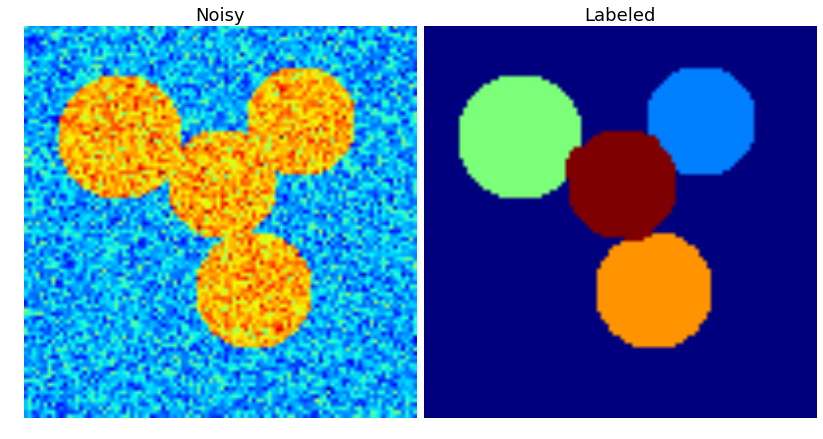

In [14]:
plt.figure(figsize=(11,8.5))
sFont = 18
plt.subplot(121)
plt.imshow(img)
ax = plt.gca()
ax.set_title("Noisy", fontsize=sFont)
plt.axis('off')
plt.subplot(122)
plt.imshow(label_im)
ax = plt.gca()
ax.set_title("Labeled", fontsize=sFont)
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

In [15]:
%reload_ext load_style
%load_style ../themes/tutorial.css